In [82]:
import torch
import random
from torchvision import datasets
import torchvision.transforms.functional as TF
from torchvision import transforms
from PIL import Image
import numpy as np
import os

In [83]:
import torch.nn.functional as F
import math

def bilinear(y):
    r""" Initialize with bilinear interpolation"""
    F_r = torch.FloatTensor([[1,2,1],[2,4,2],[1,2,1]])/4
    F_b = F_r
    F_g = torch.FloatTensor([[0,1,0],[1,4,1],[0,1,0]])/4
    bilinear_filter = torch.stack([F_r,F_g,F_b])[:,None]
    if y.is_cuda:
        bilinear_filter = bilinear_filter.cuda()
    res = F.conv2d(y, bilinear_filter,padding=1, groups=3)
    return res

def linrgb_to_srgb(img):
    """ Convert linRGB color space to sRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
#     assert img.dtype in [np.float32, np.float64]
    if isinstance(img, np.ndarray):
        img = img.copy()
    elif isinstance(img, torch.Tensor):
        img = img.clone()
    mask = img <= 0.0031308
    img[~mask] = (img[~mask]**(1/2.4))*(1.055) - 0.055
    img[mask] = img[mask] * 12.92
    return img

def srgb_to_linrgb(img):
    """ Convert sRGB color space to linRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
#     assert img.dtype in [np.float32, np.float64] 
    if isinstance(img, np.ndarray):
        img = img.copy()
    elif isinstance(img, torch.Tensor):
        img = img.clone()
    mask = img <= 0.04045
    img[~mask] = ((img[~mask]+0.055)/1.055)**2.4
    img[mask] = img[mask] / 12.92
    return img

def generate_mask(im_shape, pattern='RGGB'):
    if pattern == 'RGGB':
        # pattern RGGB
        r_mask = torch.zeros(im_shape)
        r_mask[0::2, 0::2] = 1

        g_mask = torch.zeros(im_shape)
        g_mask[::2, 1::2] = 1
        g_mask[1::2, ::2] = 1

        b_mask = torch.zeros(im_shape)
        b_mask[1::2, 1::2] = 1

        mask = torch.zeros((3,) + im_shape)
        mask[0, :, :] = r_mask
        mask[1, :, :] = g_mask
        mask[2, :, :] = b_mask
        return mask

In [3]:
from transforms.noising import PoissonGaussianNoise
from transforms.noising import realistic_noise

to_tensor = transforms.ToTensor()
class NoisedBayerDataset(datasets.ImageFolder):
    '''
    '''
    def __init__(self, dirs, noise_transform=None, scaler=1):

        super(NoisedBayerDataset, self).__init__(dirs, transform)
        self.noise_transform = noise_transform
        self.scaler = scaler

    def __getitem__(self, index):
        '''
        Args:
            index: Index of the triplet or the matches - not of a single image
        Returns:
        '''

        def load(img_path):
            """Convert image into numpy array
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """

            img = self.loader(img_path)
            return img

        img_path, class_id = self.imgs[index]
        img = load(img_path)
        img = np.asarray(img)/255.
        img = img*self.scaler
        img = srgb_to_linrgb(img)
        img = to_tensor(img).float()
        c, h, w = img.shape
        raw_img = generate_mask((h,w))*img
#         noised_raw_img = self.noise_transform(raw_img)
        if random.random() < 0.7:
            noised_raw_img = torch.from_numpy(realistic_noise(raw_img, 0.15, 0.15)).float()
        else:
            noised_raw_img = raw_img
            
        return 255*noised_raw_img, 255*img, class_id, os.path.relpath(img_path, self.root)

In [4]:
train_data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
transform = transforms.Compose([
                         PoissonGaussianNoise(a=0.09, b=0.09, threshold=1)
                     ])
noised_dataset = NoisedBayerDataset(train_data_dir, noise_transform=transform, scaler=0.6)

In [5]:
noised_raw, gt, _, _ = noised_dataset[0]

In [6]:
_

'0000045/001.png'

In [13]:
os.path.join("/home/safin/datasets/t/", "home/safin/datasets/CASIA-WebFace/")

'/home/safin/datasets/t/home/safin/datasets/CASIA-WebFace/'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

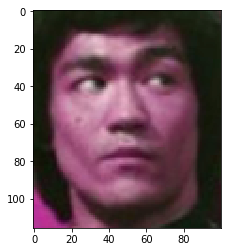

In [8]:
plt.imshow(linrgb_to_srgb(gt.permute(1,2,0).numpy()/255)/0.6)

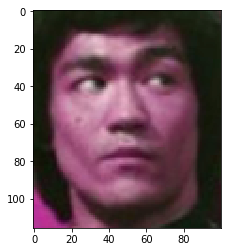

In [28]:
plt.imshow(linrgb_to_srgb(gt.permute(1,2,0).numpy()/255)/0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


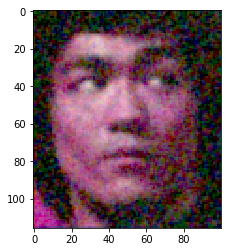

In [9]:
plt.imshow(linrgb_to_srgb(bilinear(torch.from_numpy(noised_raw).float().unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255)/0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


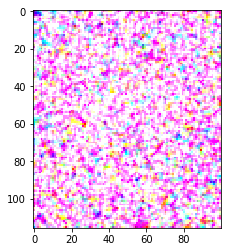

In [37]:
plt.imshow(linrgb_to_srgb(bilinear(noised_raw.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255)/0.6)

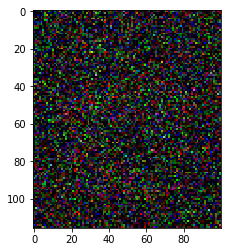

In [38]:
plt.imshow(noised_raw.permute(1,2,0).numpy()/255)

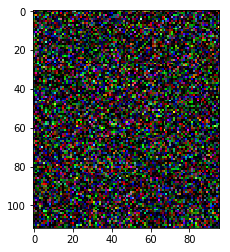

In [81]:
plt.imshow(noised_raw.permute(1,2,0).numpy()/255)

In [156]:
import tqdm
import queue
import threading
from PIL import Image
import numpy as np
import os

num_worker_threads = 10

def do_work(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(img.clip(0,255).astype(np.uint8)).save(path)

class ImageSaver(threading.Thread):
    def __init__(self, q, output_path):
        threading.Thread.__init__(self)
        self.q = q
        self.output_path = output_path
        
    def run(self):
        while True:
            item = self.q.get()
            if item is None:
                break
            img, path = item
            path = os.path.join(self.output_path, path)
            do_work(img, path)
            self.q.task_done()

In [8]:
q_noised = queue.Queue()
threads_noised = []

q_gt_lin = queue.Queue()
threads_gt_lin = []

bayer_path = "/home/safin/datasets/new_CASIA/bayer"

for i in range(num_worker_threads):
    t = ImageSaver(q_noised, bayer_path)
    t.start()
    threads_noised.append(t)

gt_lin_path = "/home/safin/datasets/new_CASIA/gt_lin"

for i in range(num_worker_threads):
    t = ImageSaver(q_gt_lin, gt_lin_path)
    t.start()
    threads_gt_lin.append(t)

In [17]:
noised.shape

(3, 116, 100)

In [15]:
Image.fromarray(noised.clip(0,255).astype(np.uint8))

TypeError: Cannot handle this data type

In [9]:
import time

t_start = time.time()

for sample in tqdm.tqdm_notebook(noised_dataset):
    noised, gt_lin, _ , path = sample
    noised = noised.permute(1,2,0).numpy()
    gt_lin = gt_lin.permute(1,2,0).numpy()
    q_noised.put_nowait((noised, path))
    q_gt_lin.put_nowait((gt_lin, path))


q_noised.join()
for i in range(num_worker_threads):
    q_noised.put(None)

for t in threads_noised:
    t.join()
    
q_gt_lin.join()
for i in range(num_worker_threads):
    q_gt_lin.put(None)

for t in threads_gt_lin:
    t.join()

t_end = time.time()
print(t_end-t_start)


2246.562447786331


In [10]:
from datasets.noised import DemosaicDataset

In [13]:
train_data_dir = "/home/safin/datasets/CASIA-WebFace_linRGB/"
transform = transforms.Compose([
                         transforms.ToTensor()
                     ])
noised_dataset = DemosaicDataset(train_data_dir, transform=transform)

In [21]:
noised_raw, gt, _ = noised_dataset[2]

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

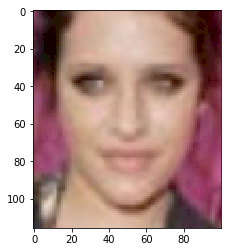

In [23]:
plt.imshow(linrgb_to_srgb(gt.permute(1,2,0).numpy()/255)/0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


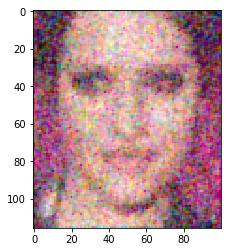

In [24]:
plt.imshow(linrgb_to_srgb(bilinear(noised_raw.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255)/0.6)

In [25]:
import numpy as np
sig_read_linspace = np.linspace(-3,-1.5,4)
sig_shot_linspace = np.linspace(-2,-1,4)

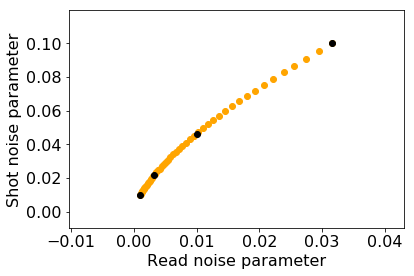

In [80]:
fontsize_global = 16
fig = plt.figure()
ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.scatter(np.power(10., sig_read_linspace_all), np.power(10., sig_shot_linspace_all), color="orange")
ax.scatter(np.power(10., sig_read_linspace), np.power(10., sig_shot_linspace), color="black")
ax.set_xlabel("Read noise parameter", fontsize = fontsize_global)
ax.set_ylabel("Shot noise parameter", fontsize = fontsize_global)
plt.setp(ax.get_xticklabels(), fontsize = fontsize_global)
plt.setp(ax.get_yticklabels(), fontsize = fontsize_global)
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=8)
fig.show()
# plt.title("")

In [40]:
sig_read_linspace_all = np.linspace(-3,-1.5)
sig_shot_linspace_all = np.linspace(-2,-1)

In [31]:
sig_read_linspace_all = np.linspace(-2.5,-1.4, 50)
sig_shot_linspace_all = np.linspace(-3,-2, 50)

In [85]:
import torchvision
transform = transforms.Compose([
                transforms.CenterCrop((112,96)),
                transforms.ToTensor(),
            ])

data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)

In [88]:
dataset[0][0]

tensor([[[0.1373, 0.1333, 0.1255,  ..., 0.1529, 0.1725, 0.1804],
         [0.1333, 0.1373, 0.1294,  ..., 0.1412, 0.1686, 0.1765],
         [0.1412, 0.1451, 0.1373,  ..., 0.1373, 0.1647, 0.1804],
         ...,
         [0.7216, 0.7255, 0.7373,  ..., 0.1137, 0.1098, 0.1098],
         [0.7137, 0.7176, 0.7294,  ..., 0.1255, 0.1020, 0.1059],
         [0.7020, 0.7098, 0.7176,  ..., 0.1804, 0.1686, 0.1451]],

        [[0.1843, 0.1804, 0.1765,  ..., 0.2000, 0.2000, 0.1961],
         [0.1804, 0.1843, 0.1765,  ..., 0.1882, 0.1961, 0.2000],
         [0.1765, 0.1843, 0.1765,  ..., 0.1804, 0.1922, 0.2039],
         ...,
         [0.1922, 0.1882, 0.1804,  ..., 0.1098, 0.0980, 0.0902],
         [0.2078, 0.1961, 0.1922,  ..., 0.1255, 0.0980, 0.0941],
         [0.2196, 0.2118, 0.2000,  ..., 0.1843, 0.1686, 0.1373]],

        [[0.1059, 0.1020, 0.0980,  ..., 0.1451, 0.1529, 0.1608],
         [0.1020, 0.1059, 0.0980,  ..., 0.1333, 0.1490, 0.1608],
         [0.1020, 0.1098, 0.1020,  ..., 0.1255, 0.1490, 0.

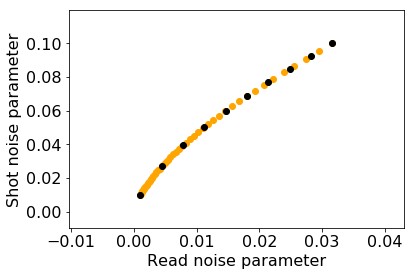

In [189]:
fig = plt.figure()
ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.scatter(np.power(10., sig_read_linspace_all), np.power(10., sig_shot_linspace_all), color="orange")
ax.scatter(sig_read_, sig_shot_, color="black")
ax.set_xlabel("Read noise parameter", fontsize = fontsize_global)
ax.set_ylabel("Shot noise parameter", fontsize = fontsize_global)
plt.setp(ax.get_xticklabels(), fontsize = fontsize_global)
plt.setp(ax.get_yticklabels(), fontsize = fontsize_global)
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=8)
fig.show()

In [140]:
sig_shot_[0] - sig_shot_[-1]

-0.14999999845084683

0.001 0.010000000000000002
0.0044025307335204215 0.02686178884848246
0.007805061467040842 0.039347536936921106
0.011207592200561264 0.05008121772672979
0.014610122934081683 0.05976348484109538
0.018012653667602106 0.06871503930199904
0.021415184401122528 0.07711660092901536
0.024817715134642947 0.08508268698817763
0.02822024586816337 0.09269163201314533
0.03162277660168379 0.1
0.15 0.15


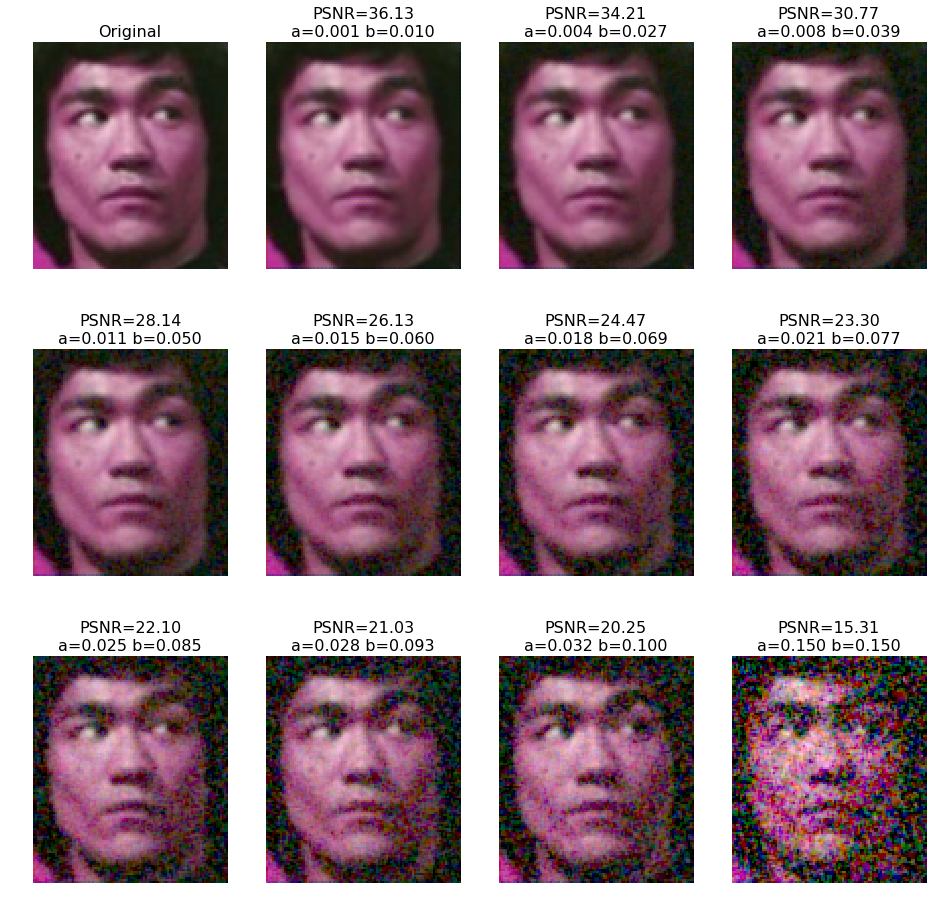

In [149]:
from transforms.noising import realistic_noise
gt = dataset[0][0]
img = gt
img = img*0.6
img = srgb_to_linrgb(img)
c, h, w = img.shape
raw_img = generate_mask((h,w))*img

from loss import PSNR

fig_w = 16
fig_h = 16
fig=plt.figure(figsize=(fig_w, fig_h))
rows = 3
columns = 4





sig_read_ = np.power(10., sig_read_linspace)
sig_shot_ = np.power(10., sig_shot_linspace)
a = (sig_shot_linspace[0] - sig_shot_linspace[-1])/( sig_read_linspace[0] - sig_read_linspace[-1])
b = np.power(10., sig_shot_linspace[0]-a*sig_read_linspace[0])
sig_read_ = np.linspace(sig_read_[0], sig_read_[-1], 10)
sig_shot_ = np.power(sig_read_, a)*b
# sig_shot_ = np.linspace(sig_shot_[0], sig_shot_[-1], 10)
sig_read_ = np.append(sig_read_, 0.15)
sig_shot_ = np.append(sig_shot_, 0.15)


fig.add_subplot(rows, columns, 1)
plt.imshow(gt.permute(1,2,0))
plt.axis('off')
plt.title("Original",fontsize = fontsize_global)
i = 1
for a, b in zip(sig_read_, sig_shot_):
    noised_raw = torch.from_numpy(realistic_noise(raw_img, a, b)).float()
    noised = linrgb_to_srgb(bilinear(noised_raw.unsqueeze(0)).squeeze(0))/0.6
    noised = noised.clamp(0,1)
    fig.add_subplot(rows, columns, 1+i)
    plt.imshow(noised.permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(noised.unsqueeze(0), gt.unsqueeze(0))
    plt.title("PSNR=%.2f\na=%.3f b=%.3f" % (cur_psnr.item(), a, b), fontsize = fontsize_global)
    print(a,b)  
    i+=1

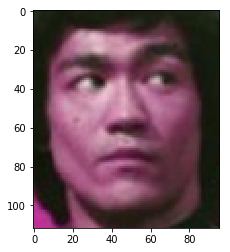

In [213]:
plt.imshow(gt.permute(1,2,0))

0.021415184401122528 0.07711660092901536


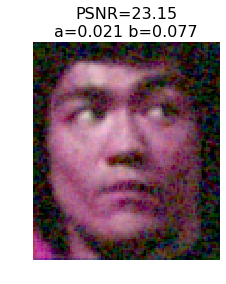

0.024817715134642947 0.08508268698817763


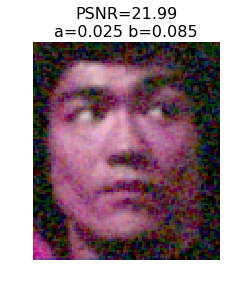

0.02822024586816337 0.09269163201314533


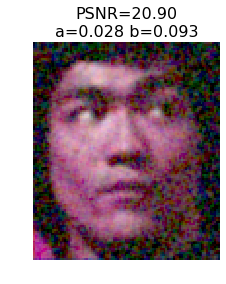

0.03162277660168379 0.1


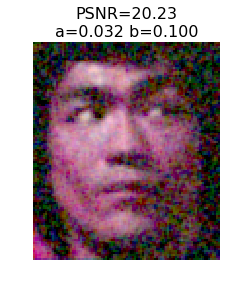

In [216]:
for a, b in zip(sig_read_4_, sig_shot_4_):
    noised_raw = torch.from_numpy(realistic_noise(raw_img, a, b)).float()
    noised = linrgb_to_srgb(bilinear(noised_raw.unsqueeze(0)).squeeze(0))/0.6
    noised = noised.clamp(0,1)
    plt.imshow(noised.permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(noised.unsqueeze(0), gt.unsqueeze(0))
    plt.title("PSNR=%.2f\na=%.3f b=%.3f" % (cur_psnr.item(), a, b), fontsize = fontsize_global)
    print(a,b)  
    plt.show();
    i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


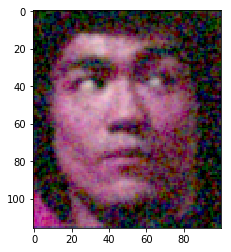

In [247]:
plt.imshow(linrgb_to_srgb(bilinear(noised_dataset[0][0].unsqueeze(0)/255).squeeze(0)).permute(1,2,0)/0.6)

In [151]:
sig_read_ = sig_read_[:-1]
sig_shot_ = sig_shot_[:-1]

In [206]:
sig_shot_[-4:]

array([0.0771166 , 0.08508269, 0.09269163, 0.1       ])

In [207]:
sig_read_4_ = sig_read_[-4:]
sig_shot_4_ = sig_shot_[-4:]

In [208]:
from transforms.noising import PoissonGaussianNoise
from transforms.noising import realistic_noise

to_tensor = transforms.ToTensor()
class NoisedBayerDataset(datasets.ImageFolder):
    '''
    '''
    def __init__(self, dirs, noise_transform=None, scaler=1):

        super(NoisedBayerDataset, self).__init__(dirs, transform)
        self.noise_transform = noise_transform
        self.scaler = scaler

    def __getitem__(self, index):
        '''
        Args:
            index: Index of the triplet or the matches - not of a single image
        Returns:
        '''

        def load(img_path):
            """Convert image into numpy array
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """

            img = self.loader(img_path)
            return img

        img_path, class_id = self.imgs[index]
        img = load(img_path)
        img = np.asarray(img)/255.
        img = img*self.scaler
        img = srgb_to_linrgb(img)
        img = to_tensor(img).float()
        c, h, w = img.shape
        raw_img = generate_mask((h,w))*img
#         noised_raw_img = self.noise_transform(raw_img)
        if random.random() < 0.8:
            idx = random.randint(0, len(sig_read_4_)-1)
            a = sig_read_4_[idx]
            b = sig_shot_4_[idx]
            noised_raw_img = torch.from_numpy(realistic_noise(raw_img, a, b)).float()
        else:
            noised_raw_img = raw_img
            
        return 255*noised_raw_img, 255*img, class_id, os.path.relpath(img_path, self.root)

In [204]:
random.random()

0.9003307190639454

In [190]:
sig_read_

array([0.001     , 0.00440253, 0.00780506, 0.01120759, 0.01461012,
       0.01801265, 0.02141518, 0.02481772, 0.02822025, 0.03162278])

In [212]:
noised_dataset.scaler

0.6

In [209]:
train_data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
noised_dataset = NoisedBayerDataset(train_data_dir, scaler=0.6)

In [210]:
q_noised = queue.Queue()
threads_noised = []

bayer_path = "/home/safin/datasets/new_CASIA/bayer"

for i in range(num_worker_threads):
    t = ImageSaver(q_noised, bayer_path)
    t.start()
    threads_noised.append(t)
import time

t_start = time.time()

for sample in tqdm.tqdm_notebook(noised_dataset):
    noised, gt_lin, _ , path = sample
    noised = noised.permute(1,2,0).numpy()
    gt_lin = gt_lin.permute(1,2,0).numpy()
    q_noised.put_nowait((noised, path))


q_noised.join()
for i in range(num_worker_threads):
    q_noised.put(None)

for t in threads_noised:
    t.join()


t_end = time.time()
print(t_end-t_start)


2752.754261493683


In [184]:
train_data_dir = "/home/safin/datasets/lfw/lfw-sphereface/"
noised_dataset = NoisedBayerDataset(train_data_dir, scaler=0.6)

In [185]:
q_noised = queue.Queue()
threads_noised = []

bayer_path = "/home/safin/datasets/lfw/lfw-sphereface_noised_bayer_10lvl/"

for i in range(num_worker_threads):
    t = ImageSaver(q_noised, bayer_path)
    t.start()
    threads_noised.append(t)
import time

t_start = time.time()

for sample in tqdm.tqdm_notebook(noised_dataset):
    noised, gt_lin, _ , path = sample
    noised = noised.permute(1,2,0).numpy()
    gt_lin = gt_lin.permute(1,2,0).numpy()
    q_noised.put_nowait((noised, path))


q_noised.join()
for i in range(num_worker_threads):
    q_noised.put(None)

for t in threads_noised:
    t.join()


t_end = time.time()
print(t_end-t_start)


72.52494215965271


In [38]:
np.log10(0.012)

-1.9208187539523751

In [39]:
np.log(np.e)

1.0